## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import sklearn
import itertools
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = keras.layers.BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = keras.layers.BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

reduce_lr_factor = [0.5, 0.75]
redice_lr_patient = [5, 3]

In [8]:
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=reduce_factor, 
                                                  min_lr=1e-12, 
                                                  monitor='val_loss', 
                                                  patience=reduce_patient, 
                                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr])

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 16s 312us/step - loss: 2.2203 - accuracy: 0.2649 - val_loss: 2.1080 - val_accuracy: 0.2338
Epoch 2/25
50000/50000 [==============================] - 21s 415us/step - loss: 1.7435 - accuracy: 0.3918 - val_loss: 1.9488 - val_accuracy: 0.3146
Epoch 3/25
50000/50000 [==============================] - 18s 354us/step - loss: 1.6239 - accuracy: 0.4283 - val_loss: 1.8144 - val_accuracy: 0.3766
Epoch 4/25
50000/50000 [==============================] - 20s 392us/step - loss: 1.5509 - accuracy: 0.4554 - val_loss: 1.7197 - val_accuracy: 0.4121
Epoch 5/25
50000/50000 [==============================] - 18s 363us/step - loss: 1.4962 - accuracy: 0.4760 - val_loss: 1.6588 - val_accuracy: 0.4285
Epoch 6/25
50000/50000 [==============================] - 20s 407us/step - loss: 1.4515 - accuracy: 0.4906 - val_loss: 1.5821 - val_accuracy: 0.449

50000/50000 [==============================] - 16s 311us/step - loss: 1.7217 - accuracy: 0.3984 - val_loss: 1.9058 - val_accuracy: 0.3197
Epoch 4/25
50000/50000 [==============================] - 16s 326us/step - loss: 1.6483 - accuracy: 0.4230 - val_loss: 1.7937 - val_accuracy: 0.3726
Epoch 5/25
50000/50000 [==============================] - 15s 303us/step - loss: 1.5942 - accuracy: 0.4420 - val_loss: 1.7104 - val_accuracy: 0.3957
Epoch 6/25
50000/50000 [==============================] - 15s 302us/step - loss: 1.5529 - accuracy: 0.4562 - val_loss: 1.6567 - val_accuracy: 0.4157
Epoch 7/25
50000/50000 [==============================] - 15s 303us/step - loss: 1.5163 - accuracy: 0.4679 - val_loss: 1.6119 - val_accuracy: 0.4264
Epoch 8/25
50000/50000 [==============================] - 15s 303us/step - loss: 1.4858 - accuracy: 0.4783 - val_loss: 1.5922 - val_accuracy: 0.4329
Epoch 9/25
50000/50000 [==============================] - 15s 303us/step - loss: 1.4575 - accuracy: 0.4888 - val_loss

50000/50000 [==============================] - 16s 313us/step - loss: 1.1901 - accuracy: 0.5797 - val_loss: 1.6777 - val_accuracy: 0.4126
Epoch 7/25
50000/50000 [==============================] - 16s 314us/step - loss: 1.1443 - accuracy: 0.5978 - val_loss: 2.2011 - val_accuracy: 0.3191
Epoch 8/25
50000/50000 [==============================] - 16s 318us/step - loss: 1.0949 - accuracy: 0.6156 - val_loss: 1.9724 - val_accuracy: 0.3345
Epoch 9/25
50000/50000 [==============================] - 16s 314us/step - loss: 1.0532 - accuracy: 0.6316 - val_loss: 2.4261 - val_accuracy: 0.2943
Epoch 10/25
50000/50000 [==============================] - 16s 315us/step - loss: 1.0127 - accuracy: 0.6456 - val_loss: 1.8835 - val_accuracy: 0.3961
Epoch 11/25
50000/50000 [==============================] - 16s 314us/step - loss: 0.9710 - accuracy: 0.6580 - val_loss: 1.8727 - val_accuracy: 0.3918

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 12/25
50000/50000 [=========

50000/50000 [==============================] - 19s 372us/step - loss: 1.6386 - accuracy: 0.4336 - val_loss: 1.7681 - val_accuracy: 0.3742
Epoch 6/25
50000/50000 [==============================] - 21s 412us/step - loss: 1.6039 - accuracy: 0.4451 - val_loss: 1.7224 - val_accuracy: 0.3933
Epoch 7/25
50000/50000 [==============================] - 18s 357us/step - loss: 1.5756 - accuracy: 0.4544 - val_loss: 1.6801 - val_accuracy: 0.4106
Epoch 8/25
50000/50000 [==============================] - 20s 391us/step - loss: 1.5500 - accuracy: 0.4641 - val_loss: 1.6583 - val_accuracy: 0.4171
Epoch 9/25
50000/50000 [==============================] - 19s 384us/step - loss: 1.5289 - accuracy: 0.4708 - val_loss: 1.6420 - val_accuracy: 0.4237
Epoch 10/25
50000/50000 [==============================] - 16s 326us/step - loss: 1.5091 - accuracy: 0.4784 - val_loss: 1.6274 - val_accuracy: 0.4334
Epoch 11/25
50000/50000 [==============================] - 16s 328us/step - loss: 1.4915 - accuracy: 0.4842 - val_lo

50000/50000 [==============================] - 15s 307us/step - loss: 1.1599 - accuracy: 0.5912 - val_loss: 1.8695 - val_accuracy: 0.3505
Epoch 9/25
50000/50000 [==============================] - 15s 309us/step - loss: 1.1199 - accuracy: 0.6063 - val_loss: 2.0852 - val_accuracy: 0.3673
Epoch 10/25
50000/50000 [==============================] - 15s 303us/step - loss: 1.0892 - accuracy: 0.6171 - val_loss: 1.6343 - val_accuracy: 0.4259
Epoch 11/25
50000/50000 [==============================] - 15s 303us/step - loss: 1.0586 - accuracy: 0.6285 - val_loss: 2.0109 - val_accuracy: 0.3486
Epoch 12/25
50000/50000 [==============================] - 15s 304us/step - loss: 1.0211 - accuracy: 0.6416 - val_loss: 1.9893 - val_accuracy: 0.3807
Epoch 13/25
50000/50000 [==============================] - 15s 305us/step - loss: 0.9877 - accuracy: 0.6547 - val_loss: 1.8162 - val_accuracy: 0.3926
Epoch 14/25
50000/50000 [==============================] - 15s 303us/step - loss: 0.9553 - accuracy: 0.6654 - val

50000/50000 [==============================] - 16s 317us/step - loss: 1.5940 - accuracy: 0.4449 - val_loss: 1.6821 - val_accuracy: 0.4019
Epoch 9/25
50000/50000 [==============================] - 16s 321us/step - loss: 1.5624 - accuracy: 0.4549 - val_loss: 1.6519 - val_accuracy: 0.4219
Epoch 10/25
50000/50000 [==============================] - 17s 334us/step - loss: 1.5353 - accuracy: 0.4646 - val_loss: 1.6412 - val_accuracy: 0.4255
Epoch 11/25
50000/50000 [==============================] - 16s 328us/step - loss: 1.5090 - accuracy: 0.4756 - val_loss: 1.6274 - val_accuracy: 0.4310
Epoch 12/25
50000/50000 [==============================] - 16s 323us/step - loss: 1.4853 - accuracy: 0.4837 - val_loss: 1.6194 - val_accuracy: 0.4346
Epoch 13/25
50000/50000 [==============================] - 17s 339us/step - loss: 1.4637 - accuracy: 0.4917 - val_loss: 1.6051 - val_accuracy: 0.4390
Epoch 14/25
50000/50000 [==============================] - 16s 325us/step - loss: 1.4434 - accuracy: 0.4983 - val

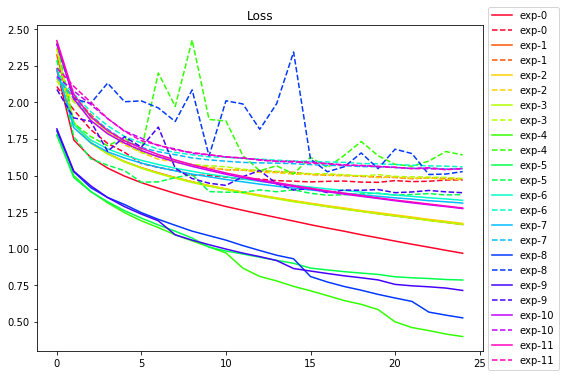

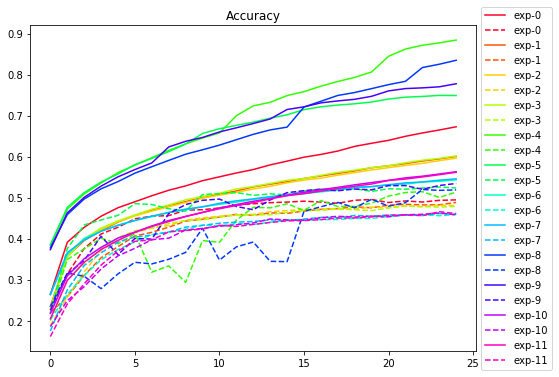

In [9]:
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()